<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Régression-Linéaire" data-toc-modified-id="Régression-Linéaire-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Régression Linéaire</a></span></li><li><span><a href="#Régression-non-linéaire" data-toc-modified-id="Régression-non-linéaire-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Régression non-linéaire</a></span></li><li><span><a href="#Sans-ENERGYSTARScore" data-toc-modified-id="Sans-ENERGYSTARScore-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Sans ENERGYSTARScore</a></span></li><li><span><a href="#Selection" data-toc-modified-id="Selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Selection</a></span></li></ul></div>

# Projet 4: Anticipez les besoins en consommation de bâtiments

# Notebook d'analyse d'energie

In [14]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [15]:
from timeit import default_timer as timer
from missingpy import MissForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pprint import pprint
from scipy import stats
from matplotlib import pyplot
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [16]:
df = pd.read_csv(
    "/Users/loicvalenti/Library/Mobile Documents/com~apple~CloudDocs/Formation Data Science/PROJET 4/2016_Building_Energy_Benchmarking.csv"
)

In [17]:
df_energy = pd.read_csv(
    "/Users/loicvalenti/Library/Mobile Documents/com~apple~CloudDocs/Formation Data Science/PROJET 4/Notebooks and files for pres/FILES NOTEBOOKS CSV/df_energy.csv"
).drop(columns="Unnamed: 0")

y_energy = pd.read_csv(
    "/Users/loicvalenti/Library/Mobile Documents/com~apple~CloudDocs/Formation Data Science/PROJET 4/Notebooks and files for pres/FILES NOTEBOOKS CSV/y_energy.csv"
).drop(columns="Unnamed: 0")

In [18]:
df_energy.describe().T.style.background_gradient(
    subset=["mean"], cmap="coolwarm"
).background_gradient(subset=["std"], cmap="coolwarm").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
BuildingAge,3340.000000,0.408825,0.285537,0.008621,0.163793,0.353448,0.586207,1.000000
PropertyGFATotal,3340.000000,0.754311,0.059207,0.644223,0.707917,0.738140,0.787623,1.000000
PropertyGFABuilding(s),3340.000000,0.755898,0.057183,0.569975,0.710993,0.741819,0.788294,1.000000
LargestPropertyUseTypeGFA,3340.000000,0.750707,0.058821,0.602759,0.706489,0.738361,0.783169,1.000000
SteamUse,3340.000000,0.038024,0.191283,0.000000,0.000000,0.000000,0.000000,1.000000
NaturalGasUse,3340.000000,0.629341,0.483054,0.000000,0.000000,1.000000,1.000000,1.000000
ElectricityUse,3340.000000,0.629341,0.483054,0.000000,0.000000,1.000000,1.000000,1.000000
ENERGYSTARScore,3340.000000,0.667212,0.242078,0.010000,0.540000,0.700000,0.860000,1.000000
T_Distribution Center,3340.000000,0.015868,0.124985,0.000000,0.000000,0.000000,0.000000,1.000000
T_High-Rise Multifamily,3340.000000,0.031138,0.173716,0.000000,0.000000,0.000000,0.000000,1.000000


## Feature Engineering

In [95]:
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(
    df_energy,
    np.ravel(y_energy),
    test_size=0.3,  # 30% des données dans le jeu de test
    shuffle=True)

In [96]:
from autofeat import AutoFeatModel, AutoFeatRegressor, FeatureSelector

AutoFeat est une librairie qui execute des opérations pré-définies sur les colonnes afin d'affiner la capacité prédictive d'un modèle de régression. L'algorithme calcule de nombreuses transformations et combinaisons de features. Ensuite choisis les plus pertinentes en suivant des critères de régularisation, et en fonction du r^2 d'une régression linéaire simple. Nous nous limitions à 2 étapes ici, afin d'éviter tout overfit.

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 40 features.
[AutoFeat] With 2338 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.9s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[featsel] 28 features after 5 feature selection runs
[featsel] 25 features after correlation filtering
[featsel] 20 features after noise filtering
[AutoFeat] Final dataframe with 40 feature columns (0 new).
[AutoFeat] Training final regression mode

[AutoFeat]    23/   23 new features ...done.
[AutoFeat] Final dataframe with 63 feature columns (23 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
9.45728786373975
2.780273 * (-PropertyGFATotal + T_SelfStorageFacility)**2
-2.408298 * (-LargestPropertyUseTypeGFA + T_Warehouse)**3
2.012431 * ENERGYSTARScore**6*T_Other**3
-1.962587 * (LargestPropertyUseTypeGFA**3 + T_Laboratory)**2
-1.959891 * (-LargestPropertyUseTypeGFA + T_DistributionCenter)**3
-1.821432 * (sqrt(ENERGYSTARScore) - PropertyGFATotal**3)**3
1.315281 * (LargestPropertyUseTypeGFA - T_WorshipFacility)**3
1.241841 * PropertyGFATotal
-1.147940 * ElectricityUse**2*PropertyGFATotal**6
-1.121147 * Abs(LargestPropertyUseTypeGFA**2 - T_Warehouse)
0.995564 * Abs(LargestPropertyUseTypeGFA**3 - T_NonresidentialCOS)
0.739478 * (NaturalGasUse + T_Laboratory)**3
-0.727288 * (sqrt(ENERGYSTARScore) - LargestPropertyUseTypeGFA)**3
0.625570 * Abs(T_Campus - T_SupermarketGroceryStore)
0.57968

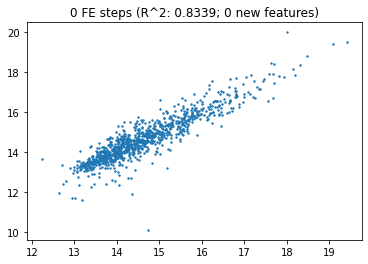

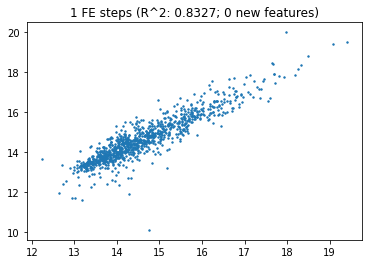

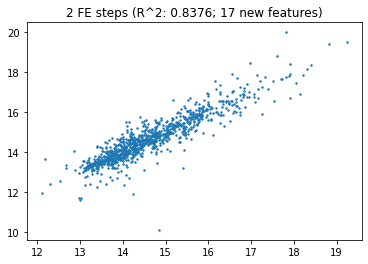

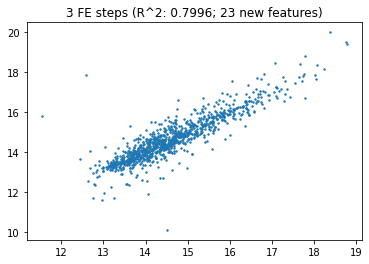

In [97]:
for steps in range(4):
    np.random.seed(55)
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1,
                              feateng_steps=steps,
                              n_jobs=-1,
                              max_gb=4,
                              transformations=("exp", "abs", "sqrt", "^2",
                                               "^3")
                              )
    df_train_energy = afreg.fit_transform(
        X_train_energy, np.ravel(y_train_energy))
    df_test_energy = afreg.transform(X_test_energy)
    r2 = afreg.score(X_test_energy, np.ravel(y_test_energy))
    print("## Final R^2: %.4f" % r2)
    plt.figure()
    plt.scatter(afreg.predict(X_test_energy), np.ravel(y_test_energy), s=2)
    plt.title("%i FE steps (R^2: %.4f; %i new features)" %
              (steps, r2, len(afreg.new_feat_cols_)))

L'auto feature engineering n'apporte aucune valeur, elle est donc rejetée.

In [ ]:
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(
    df_energy,
    np.ravel(y_energy),
    test_size=0.3,  # 30% des données dans le jeu de test
    shuffle=True)

## Régression Linéaire

Les premiers modèles que nous allons essayer seront des modèles linéares.

In [86]:
from sklearn.linear_model import RidgeCV, LassoCV, Lasso, LassoLarsCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pprint import pprint

In [93]:
def test_model_lineaire_scaled(estimator, X_train, X_test, y_train, y_test):
    estimators = [('standardize', StandardScaler()),
                  (type(estimator).__name__, estimator)]
    model_ = Pipeline(estimators)

    model_.fit(X_train, np.ravel(y_train))
    r2 = model_.score(X_test, np.ravel(y_test))
    y_pred = model_.predict(X_test)
    y_train_to_test_overfit = model_.predict(X_train)
    plt.figure()
    plt.scatter(y_pred, np.ravel(y_test), s=2)
    plt.title("%s (R^2: %.4f)" %
              (type(model_[1]).__name__, r2))
    print(type(model_[1]).__name__, "MSE: ",
          mean_squared_error(np.ravel(y_test), y_pred))
    print(type(model_[1]).__name__, "RMSE: ",
          mean_squared_error(
        np.ravel(y_train_to_test_overfit), y_train, squared=False))

    print(type(model_[1]).__name__, "alpha", model_[1].alpha_)
    importance = model_[1].coef_

    print("Score MSE model sur le jeu d'entrainement", mean_squared_error(
        np.ravel(y_train_to_test_overfit), y_train))
    print("Score RMSE model sur le jeu d'entrainement", mean_squared_error(
        np.ravel(y_train_to_test_overfit), y_train, squared=False))
    print("Score r2 model sur le jeu d'entrainement", r2_score(
        np.ravel(y_train_to_test_overfit), y_train))

    fig, ax = plt.subplots(figsize=(27, 10), dpi=300)
    ax.set_xticks([x for x in range(len(importance))])
    ax.set_xticklabels(X_train.columns, rotation=90)
    ax.bar(X_train.columns, importance)
    plt.show()
    return

RidgeCV MSE:  0.21192849557648527
RidgeCV RMSE:  0.4904732425027816
RidgeCV alpha 47.82398804402201
Score MSE model sur le jeu d'entrainement 0.24056400161119246
Score RMSE model sur le jeu d'entrainement 0.4904732425027816
Score r2 model sur le jeu d'entrainement 0.7687949129562001


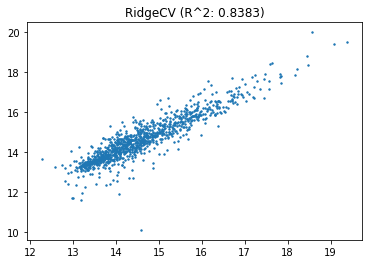

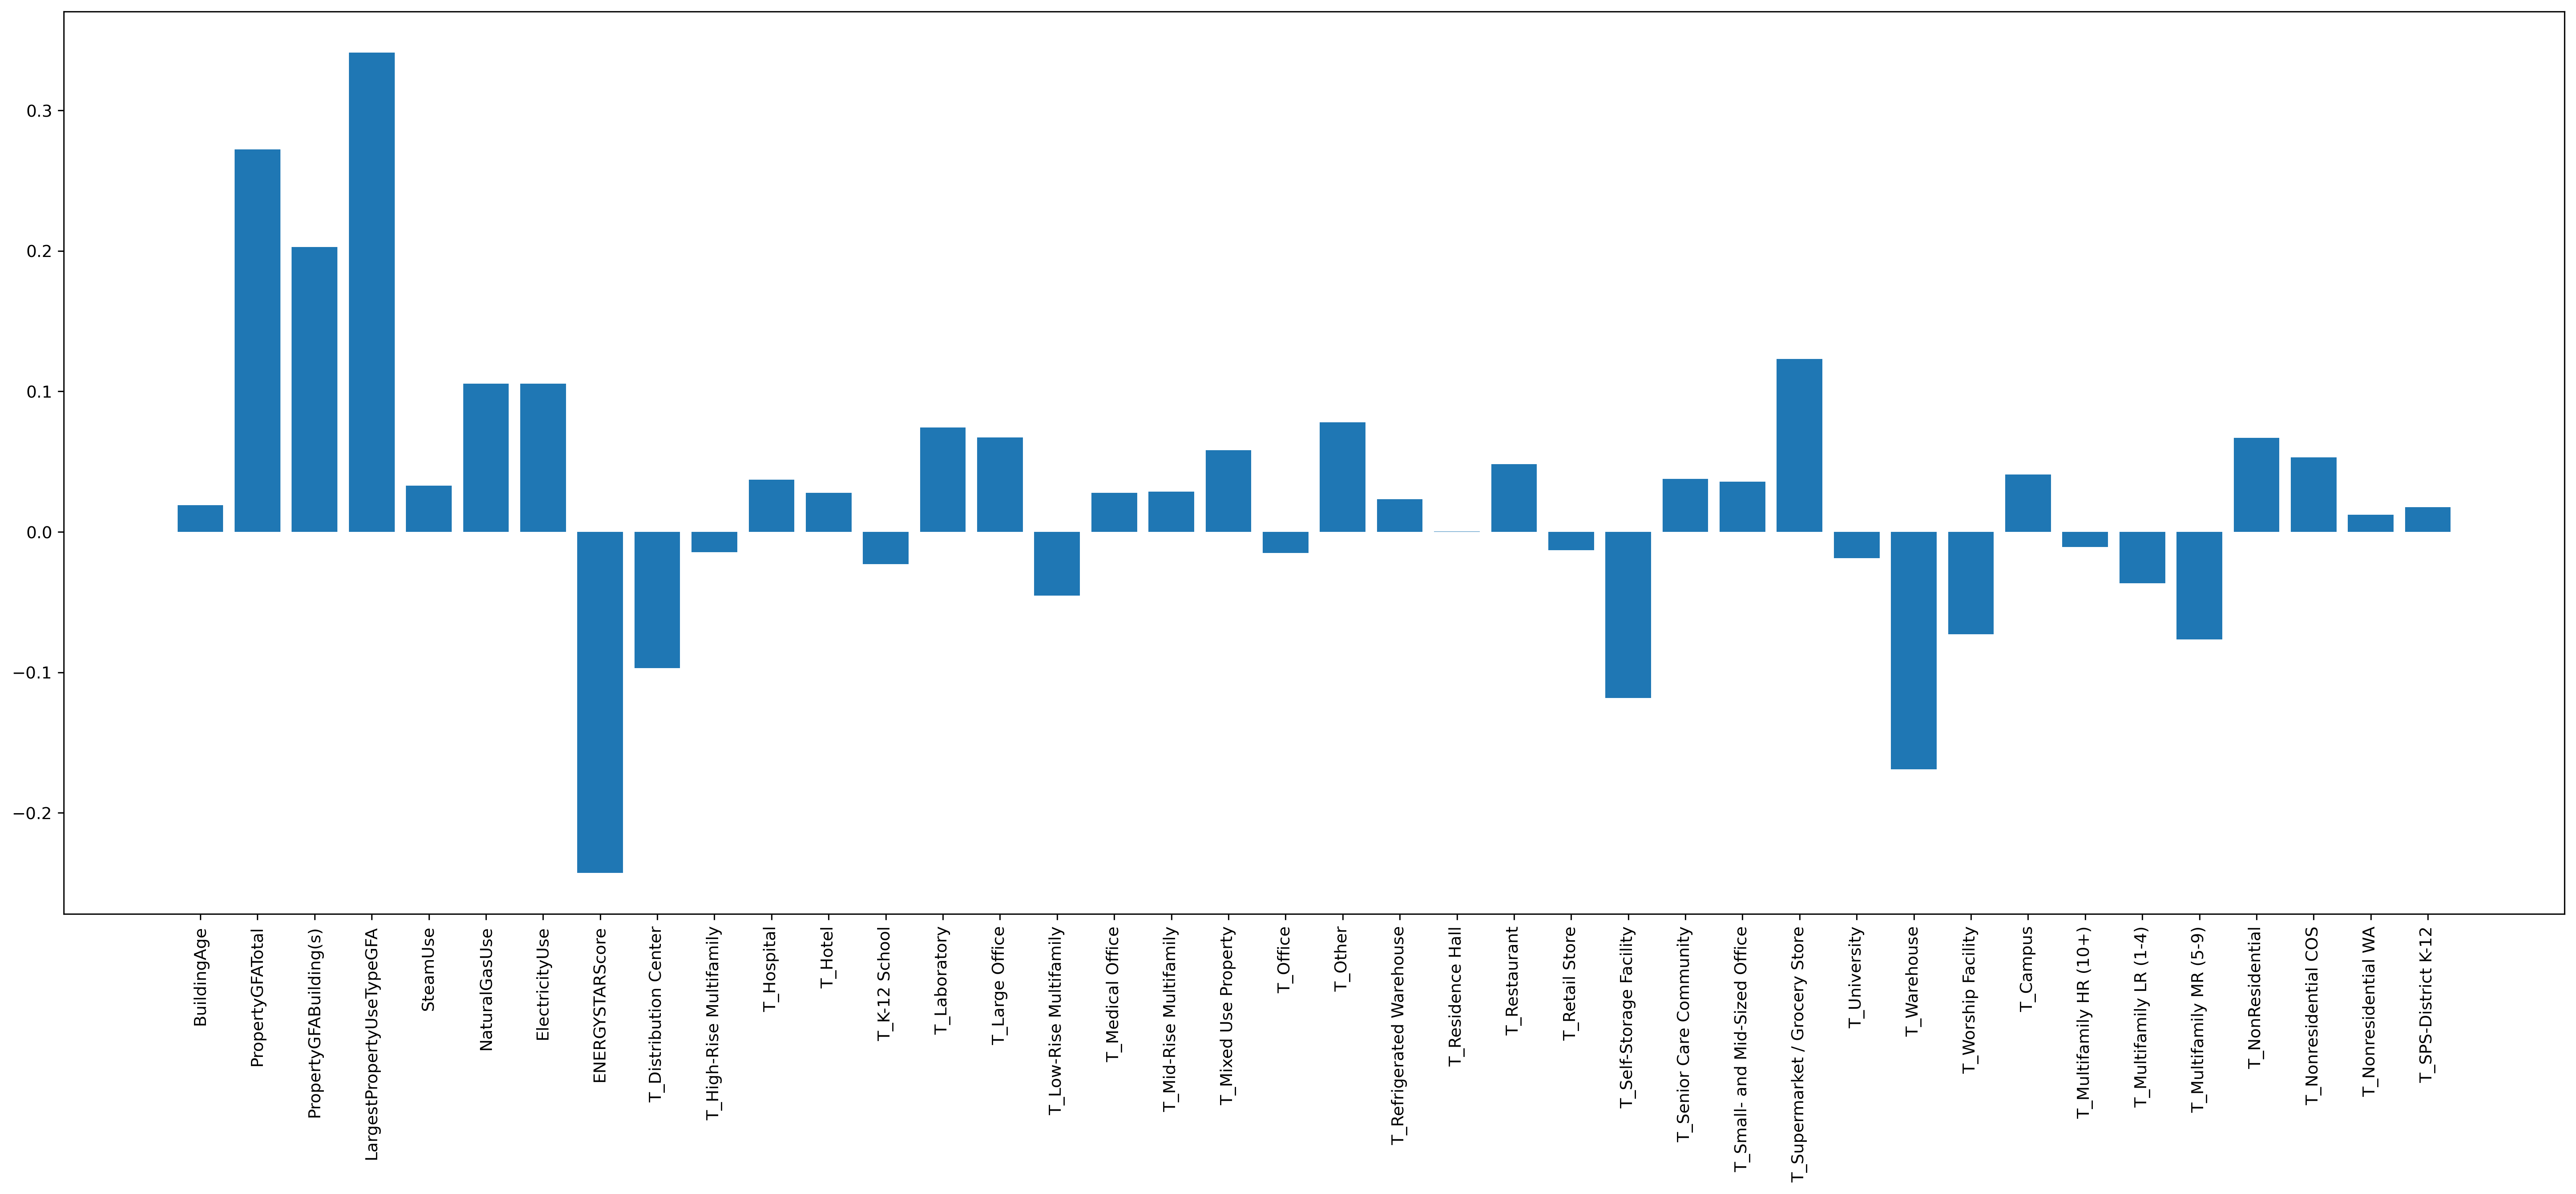

LassoCV MSE:  0.2118608775978164
LassoCV RMSE:  0.49005335525780275
LassoCV alpha 0.0001
Score MSE model sur le jeu d'entrainement 0.24015229099943022
Score RMSE model sur le jeu d'entrainement 0.49005335525780275
Score r2 model sur le jeu d'entrainement 0.7730358332710681


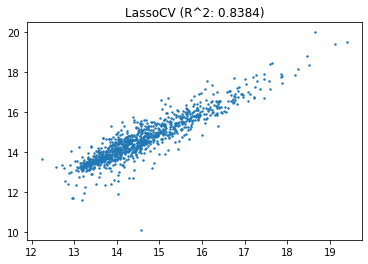

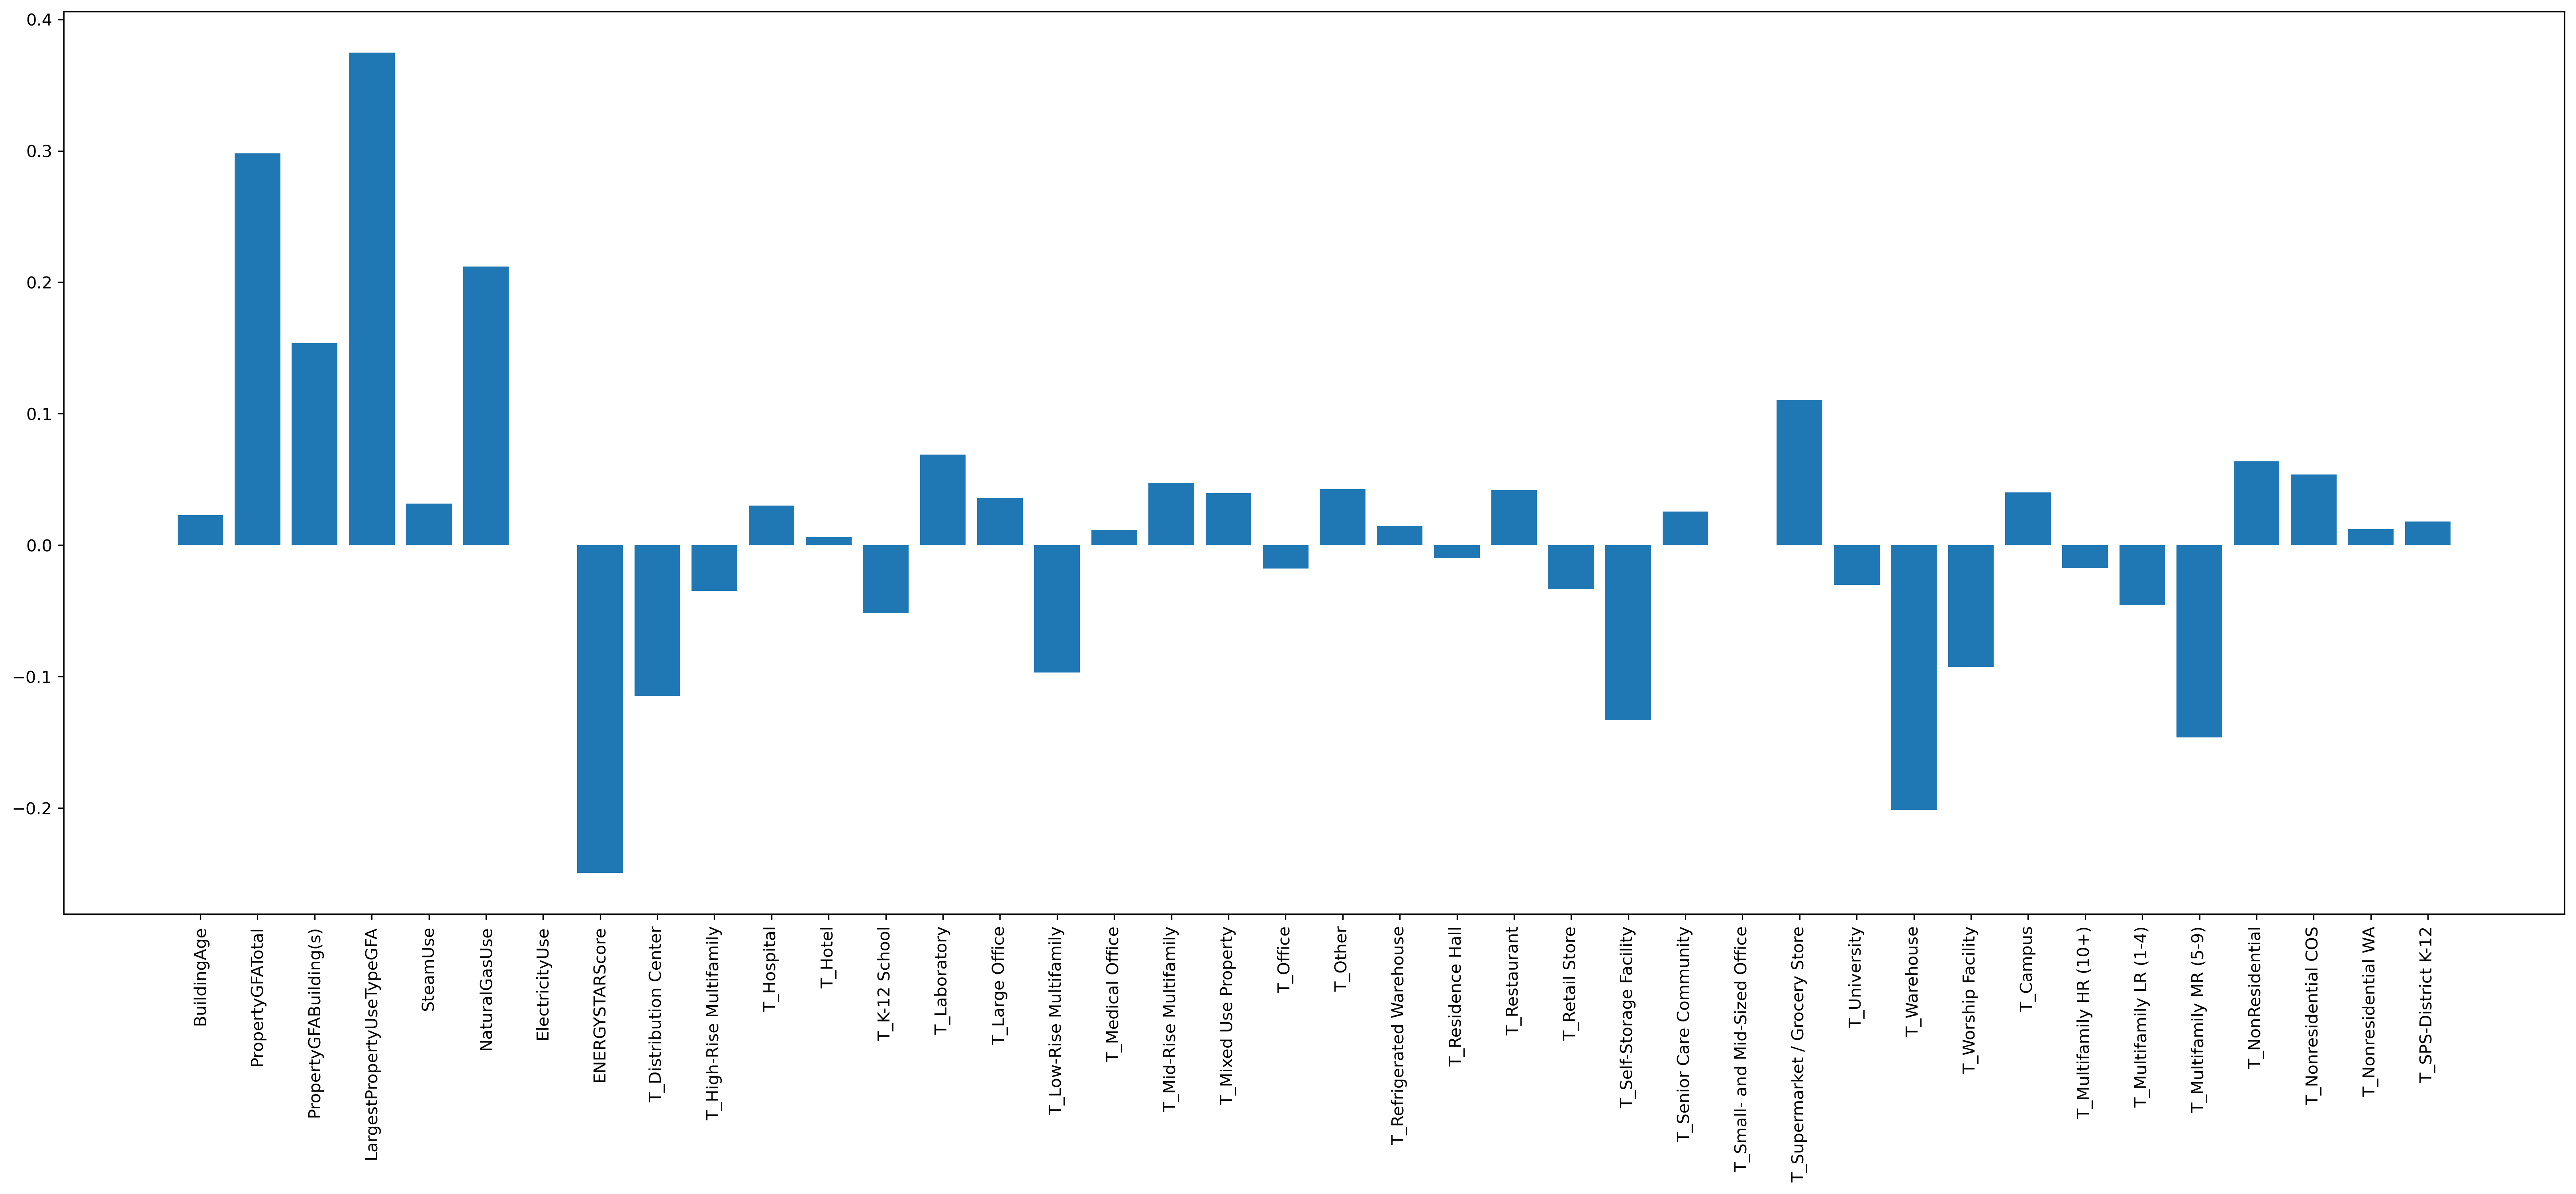

ElasticNetCV MSE:  0.21186867318410704
ElasticNetCV RMSE:  0.49074628802356607
ElasticNetCV alpha 0.0221226673467136
Score MSE model sur le jeu d'entrainement 0.24083191920890884
Score RMSE model sur le jeu d'entrainement 0.49074628802356607
Score r2 model sur le jeu d'entrainement 0.7672971510803136


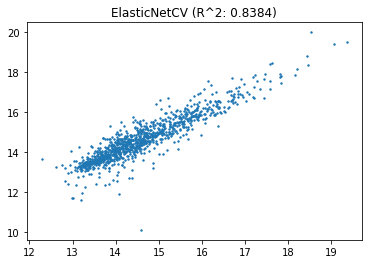

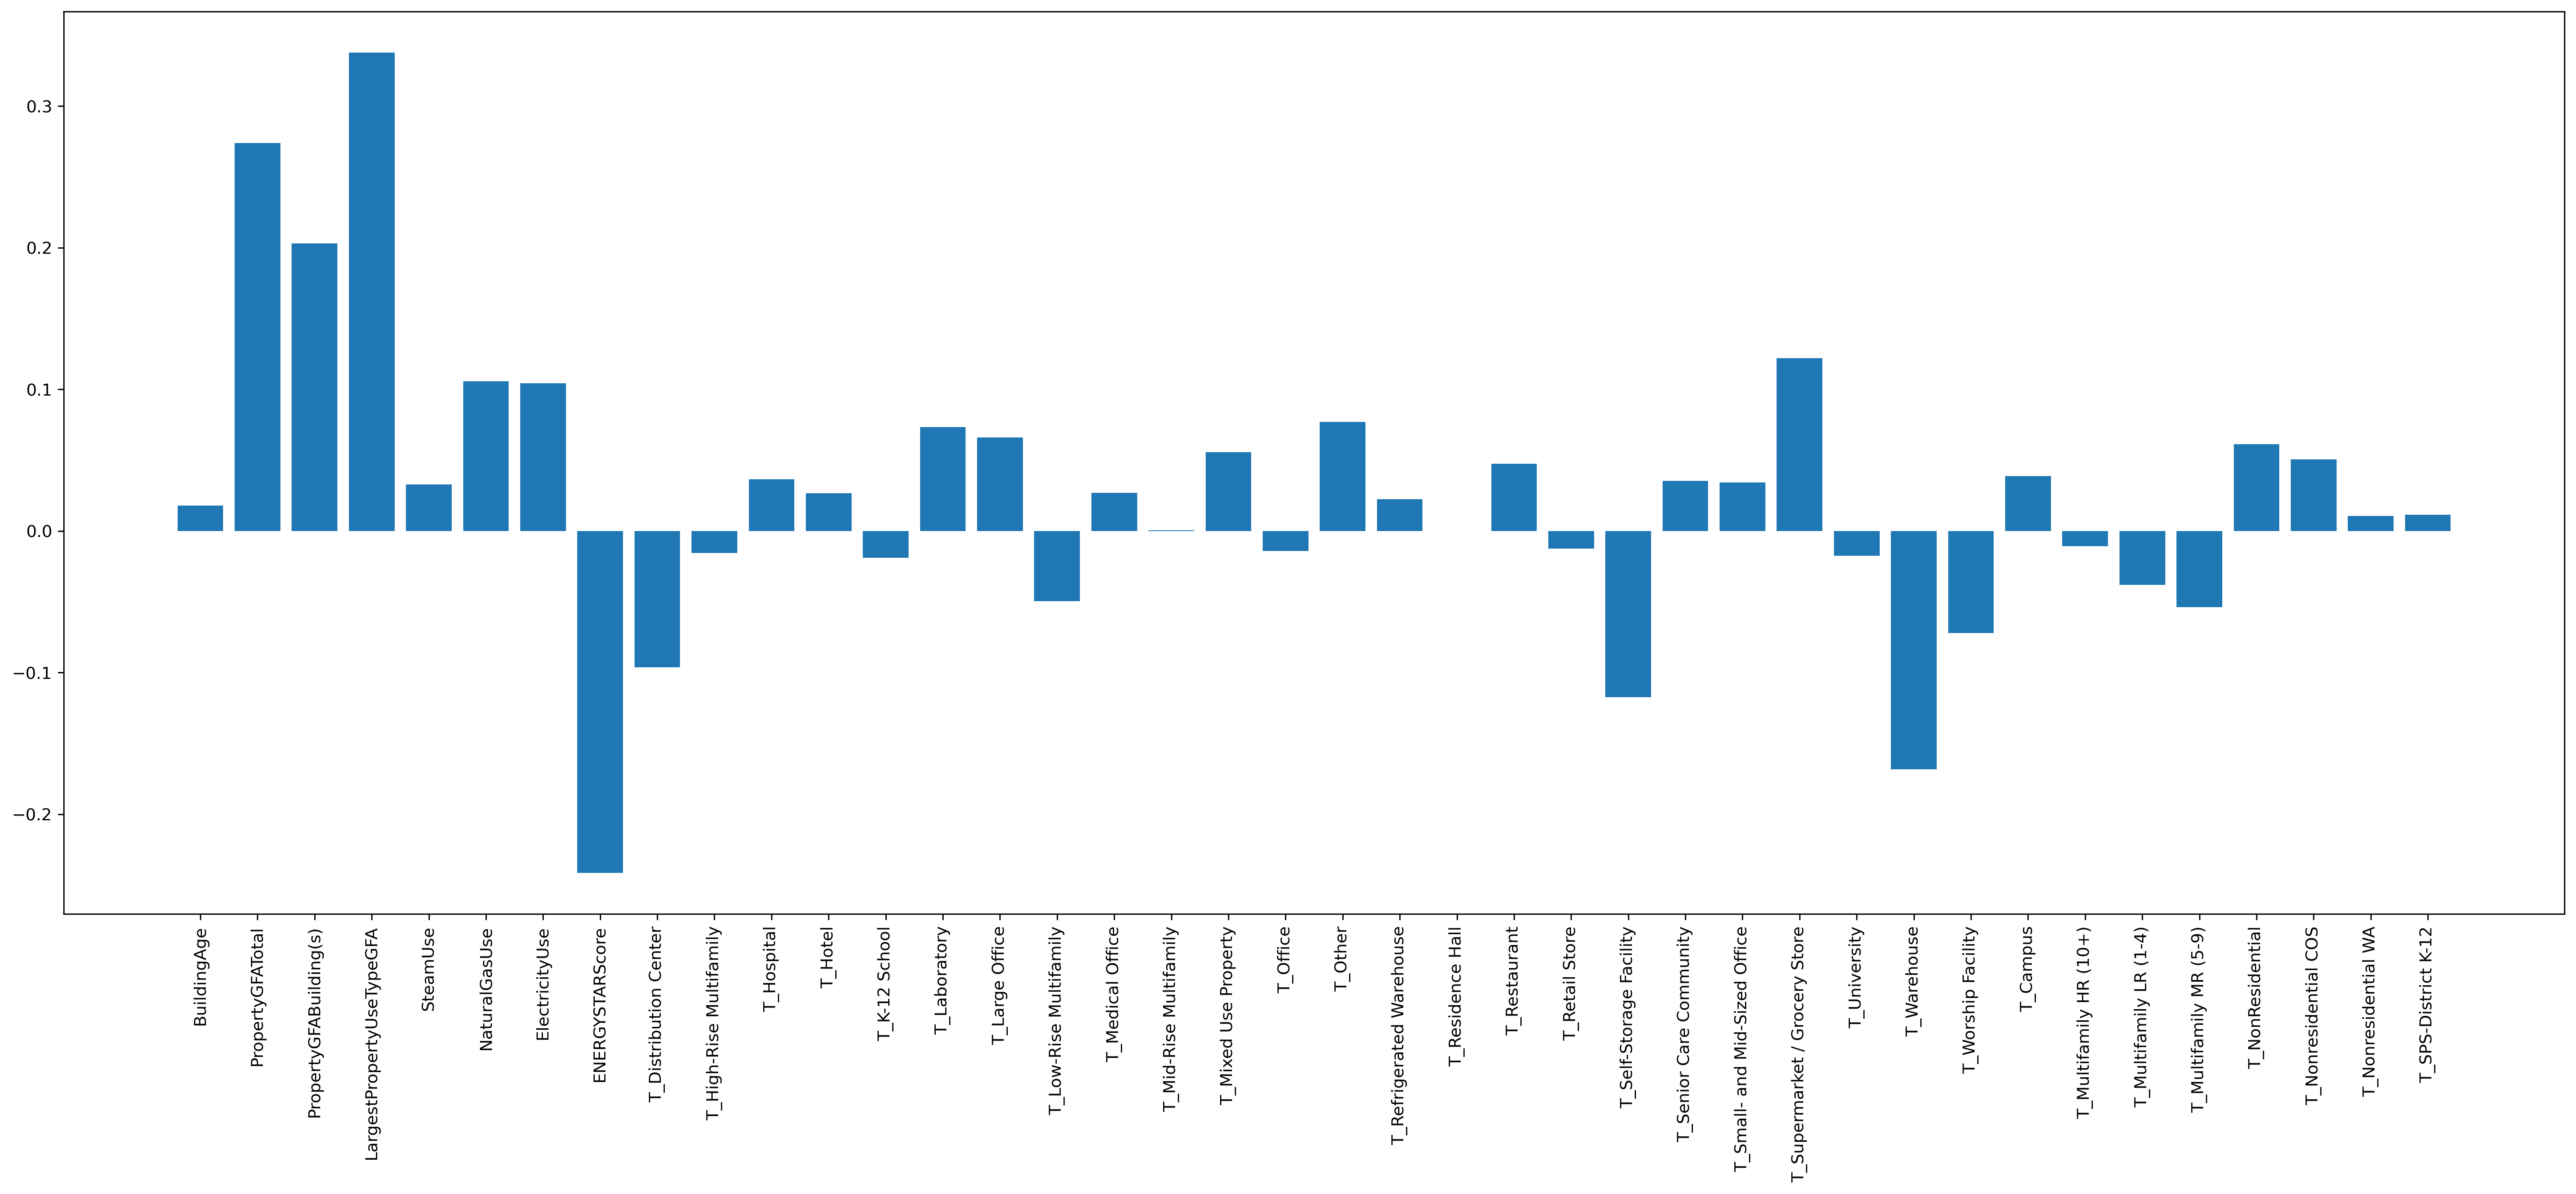

In [98]:
for model in [
    RidgeCV(alphas=np.linspace(0.0001, 200, 2000), scoring='r2'),
    LassoCV(alphas=np.linspace(0.0001, 10, 2000), max_iter=10000),
    ElasticNetCV(l1_ratio=np.linspace(0.0001, 1, 200),
                 max_iter=2000,
                 n_alphas=200)
]:
    test_model_lineaire_scaled(
        model, X_train_energy, X_test_energy, y_train_energy, y_test_energy)

## Régression non-linéaire

In [99]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [100]:
def print_results_xgboost(estimator, X_train, X_test, y_train, y_test):

    estimator.fit(X_train, y_train)

    r2 = estimator.score(X_test, y_test)
    y_pred = estimator.predict(X_test)

    y_train_to_test_overfit = estimator.predict(X_train)
    plt.figure()
    plt.scatter(estimator.predict(X_test), np.ravel(y_test), s=2)
    plt.title("%s (R^2: %.4f)" %
              (type(estimator).__name__, r2))
    y_train_to_test_overfit = estimator.predict(X_train)
    print("MSE: ",
          mean_squared_error(np.ravel(y_test), y_pred))
    print("RMSE: ",
          mean_squared_error(
              np.ravel(y_train_to_test_overfit), y_train, squared=False))

    print("Score MSE model sur le jeu d'entrainement", mean_squared_error(
        np.ravel(y_train_to_test_overfit), y_train))

    print("Score RMSE model sur le jeu d'entrainement", mean_squared_error(
        np.ravel(y_train_to_test_overfit), y_train, squared=False))

    print("Score r2 model sur le jeu d'entrainement", r2_score(
        np.ravel(y_train_to_test_overfit), y_train))

    print(estimator.best_params_)

    #estimator_features = XGBRegressor(np.ravel(estimator.best_params_))
    #estimator_features.fit(X_train, y_train)
    importance = estimator.best_estimator_.feature_importances_
    # summarize feature importance
    fig, ax = plt.subplots(figsize=(27, 10), dpi=300)
    ax.set_xticks([x for x in range(len(importance))])
    ax.set_xticklabels(X_train.columns, rotation=90)
    ax.bar(X_train.columns, importance)
    plt.show()
    return

Fitting 2 folds for each of 288 candidates, totalling 576 fits
MSE:  0.19832187682140745
RMSE:  0.336835454213715
Score MSE model sur le jeu d'entrainement 0.11345812321535972
Score RMSE model sur le jeu d'entrainement 0.336835454213715
Score r2 model sur le jeu d'entrainement 0.8988850835726105
{'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200, 'nthread': 0, 'objective': 'reg:squarederror', 'reg_alpha': 0.01, 'reg_lambda': 0.5, 'subsample': 0.3}


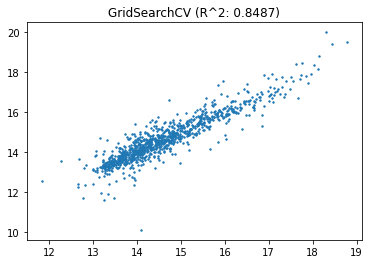

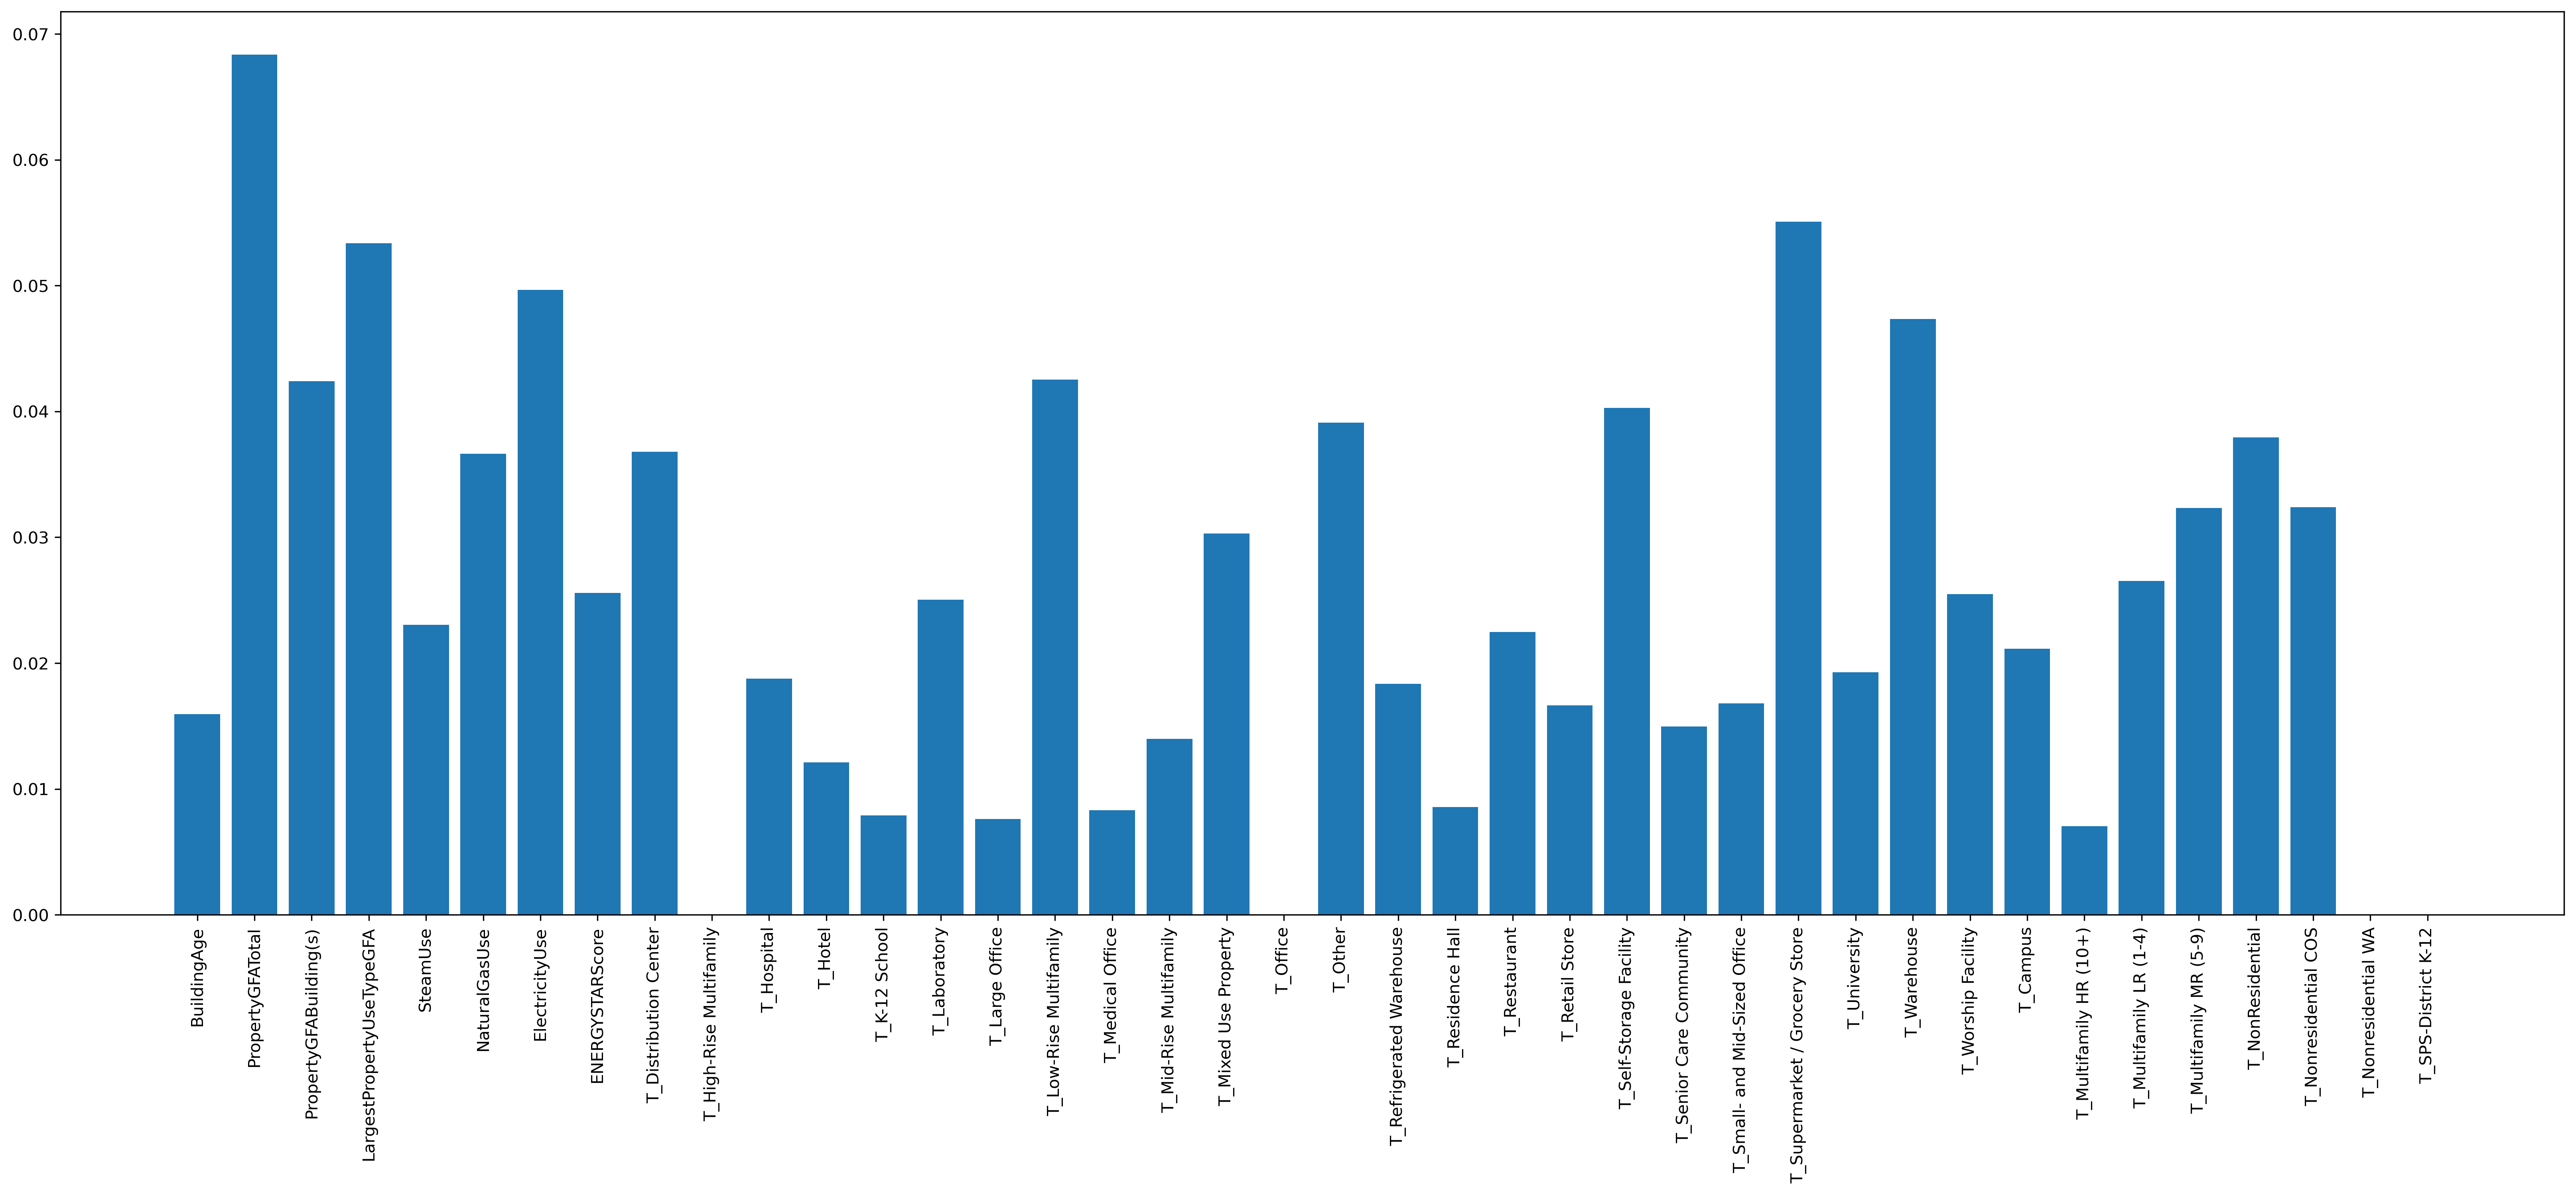

In [101]:
xgb1 = XGBRegressor()
parameters = {'nthread': [0],  # when use hyperthread, xgboost may become slower
              'objective': ['reg:squarederror'],
              'booster': ['gbtree'],
              'learning_rate': [.03, 0.07, 0.5],  # so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [2, 4],
              'subsample': [0.3, 0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100, 200],
              'reg_alpha': [0.01, 0.5],
              'reg_lambda': [0.01, 0.5]}
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv=2,
                        scoring="r2",
                        verbose=1)

print_results_xgboost(xgb_grid, X_train_energy,
                      X_test_energy, y_train_energy, y_test_energy)

## Sans ENERGYSTARScore

In [114]:
df_energy = pd.read_csv(
    "/Users/loicvalenti/Library/Mobile Documents/com~apple~CloudDocs/Formation Data Science/PROJET 4/Notebooks and files for pres/FILES NOTEBOOKS CSV/df_energy.csv"
).drop(columns="Unnamed: 0")

y_energy = pd.read_csv(
    "/Users/loicvalenti/Library/Mobile Documents/com~apple~CloudDocs/Formation Data Science/PROJET 4/Notebooks and files for pres/FILES NOTEBOOKS CSV/y_energy.csv"
).drop(columns="Unnamed: 0")

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 39 features.
[AutoFeat] With 2338 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.3s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.3s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
[featsel] 27 features after 5 feature selection runs
[featsel] 23 features after correlation filtering
[featsel] 23 features after noise filtering
[AutoFeat] Final dataframe with 39 feature columns (0 new).
[AutoFeat] Training final regression mode

[AutoFeat]    21/   21 new features ...done.
[AutoFeat] Final dataframe with 60 feature columns (21 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
8.699859208011802
2.849746 * PropertyGFATotal
2.331322 * (-PropertyGFATotal + T_SelfStorageFacility)**2
1.532488 * Abs(LargestPropertyUseTypeGFA**2 - T_Warehouse)
-1.423152 * (-LargestPropertyUseTypeGFA + T_WorshipFacility)**3
1.093306 * (PropertyGFATotal - T_DistributionCenter)**3
0.866692 * Abs(T_Campus - T_SupermarketGroceryStore)
0.665241 * Abs(SteamUse - T_SupermarketGroceryStore)
0.540785 * (-PropertyGFATotal**2 + T_MidRiseMultifamily)**2
0.525178 * (-PropertyGFATotal**2 + T_LowRiseMultifamily)**3
0.488354 * Abs(PropertyGFABuildings**2 - T_K12School)
-0.469292 * exp(-NaturalGasUse + T_Warehouse)
0.393062 * exp(SteamUse - T_LowRiseMultifamily)
0.332585 * Abs(BuildingAge**2 - T_NonResidential)
-0.279207 * exp(NaturalGasUse + SteamUse)
0.182263 * (ElectricityUse + T_NonresidentialCOS)**2


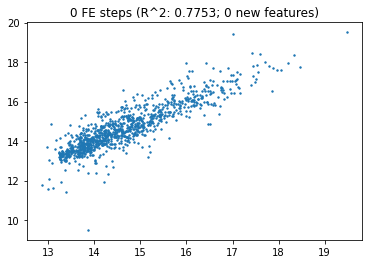

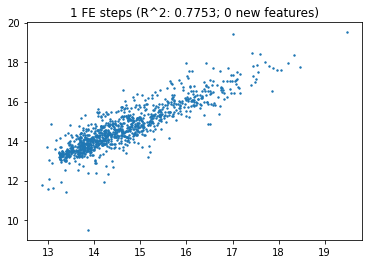

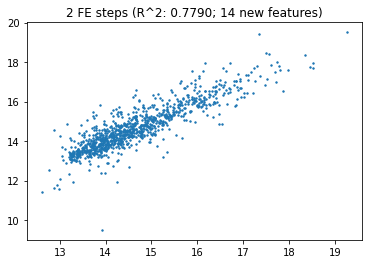

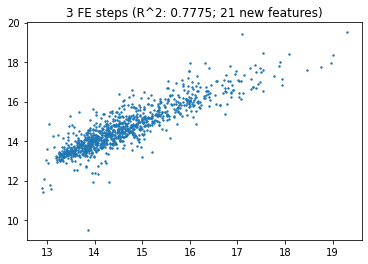

In [119]:
X_train_energy, X_test_energy, y_train_energy, y_test_energy = train_test_split(
    df_energy.drop(columns=["ENERGYSTARScore"]),
    np.ravel(y_energy),
    test_size=0.3,  # 30% des données dans le jeu de test
    shuffle=True)

for steps in range(4):
    np.random.seed(55)
    print("### AutoFeat with %i feateng_steps" % steps)
    afreg = AutoFeatRegressor(verbose=1,
                              feateng_steps=steps,
                              n_jobs=-1,
                              max_gb=4,
                              transformations=("exp", "abs", "sqrt", "^2",
                                               "^3")
                              )
    df_train_energy = afreg.fit_transform(
        X_train_energy, np.ravel(y_train_energy))
    df_test_energy = afreg.transform(X_test_energy)
    r2 = afreg.score(X_test_energy, np.ravel(y_test_energy))
    print("## Final R^2: %.4f" % r2)
    plt.figure()
    plt.scatter(afreg.predict(X_test_energy), np.ravel(y_test_energy), s=2)
    plt.title("%i FE steps (R^2: %.4f; %i new features)" %
              (steps, r2, len(afreg.new_feat_cols_)))

Une fois de plus, même sans l'ENERGYSTARScore, l'autofeat n'améliore pas la performance, nous ne l'utilisons pas.

In [120]:
def Test_Sans_ENERGYSTARScore(X_train, X_test, y_train, y_test):

    for model in [
        RidgeCV(alphas=np.linspace(0.0001, 200, 2000), scoring='r2'),
        LassoCV(alphas=np.linspace(0.0001, 10, 10000), max_iter=2000),
        ElasticNetCV(l1_ratio=np.linspace(0.0001, 1, 200),
                     max_iter=2000,
                     n_alphas=200)
    ]:
        test_model_lineaire_scaled(model, X_train, X_test, y_train, y_test)

    xgb1 = XGBRegressor()
    parameters = {'nthread': [0],  # when use hyperthread, xgboost may become slower
                  'objective': ['reg:squarederror'],
                  'booster': ['gbtree'],
                  'learning_rate': [.03, 0.07, 0.5],  # so called `eta` value
                  'max_depth': [5, 6, 7],
                  'min_child_weight': [2, 4],
                  'subsample': [0.3, 0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators': [100, 200],
                  'reg_alpha': [0.01, 0.5],
                  'reg_lambda': [0.01, 0.5]}
    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            cv=2,
                            scoring="r2",
                            verbose=1)

    print_results_xgboost(xgb_grid, X_train, X_test, y_train, y_test)

    return

RidgeCV MSE:  0.29815138464248453
RidgeCV RMSE:  0.5308143650079693
RidgeCV alpha 75.83798104052026
Score MSE model sur le jeu d'entrainement 0.2817638900988137
Score RMSE model sur le jeu d'entrainement 0.5308143650079693
Score r2 model sur le jeu d'entrainement 0.7094131338830072


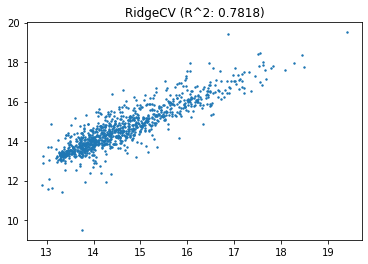

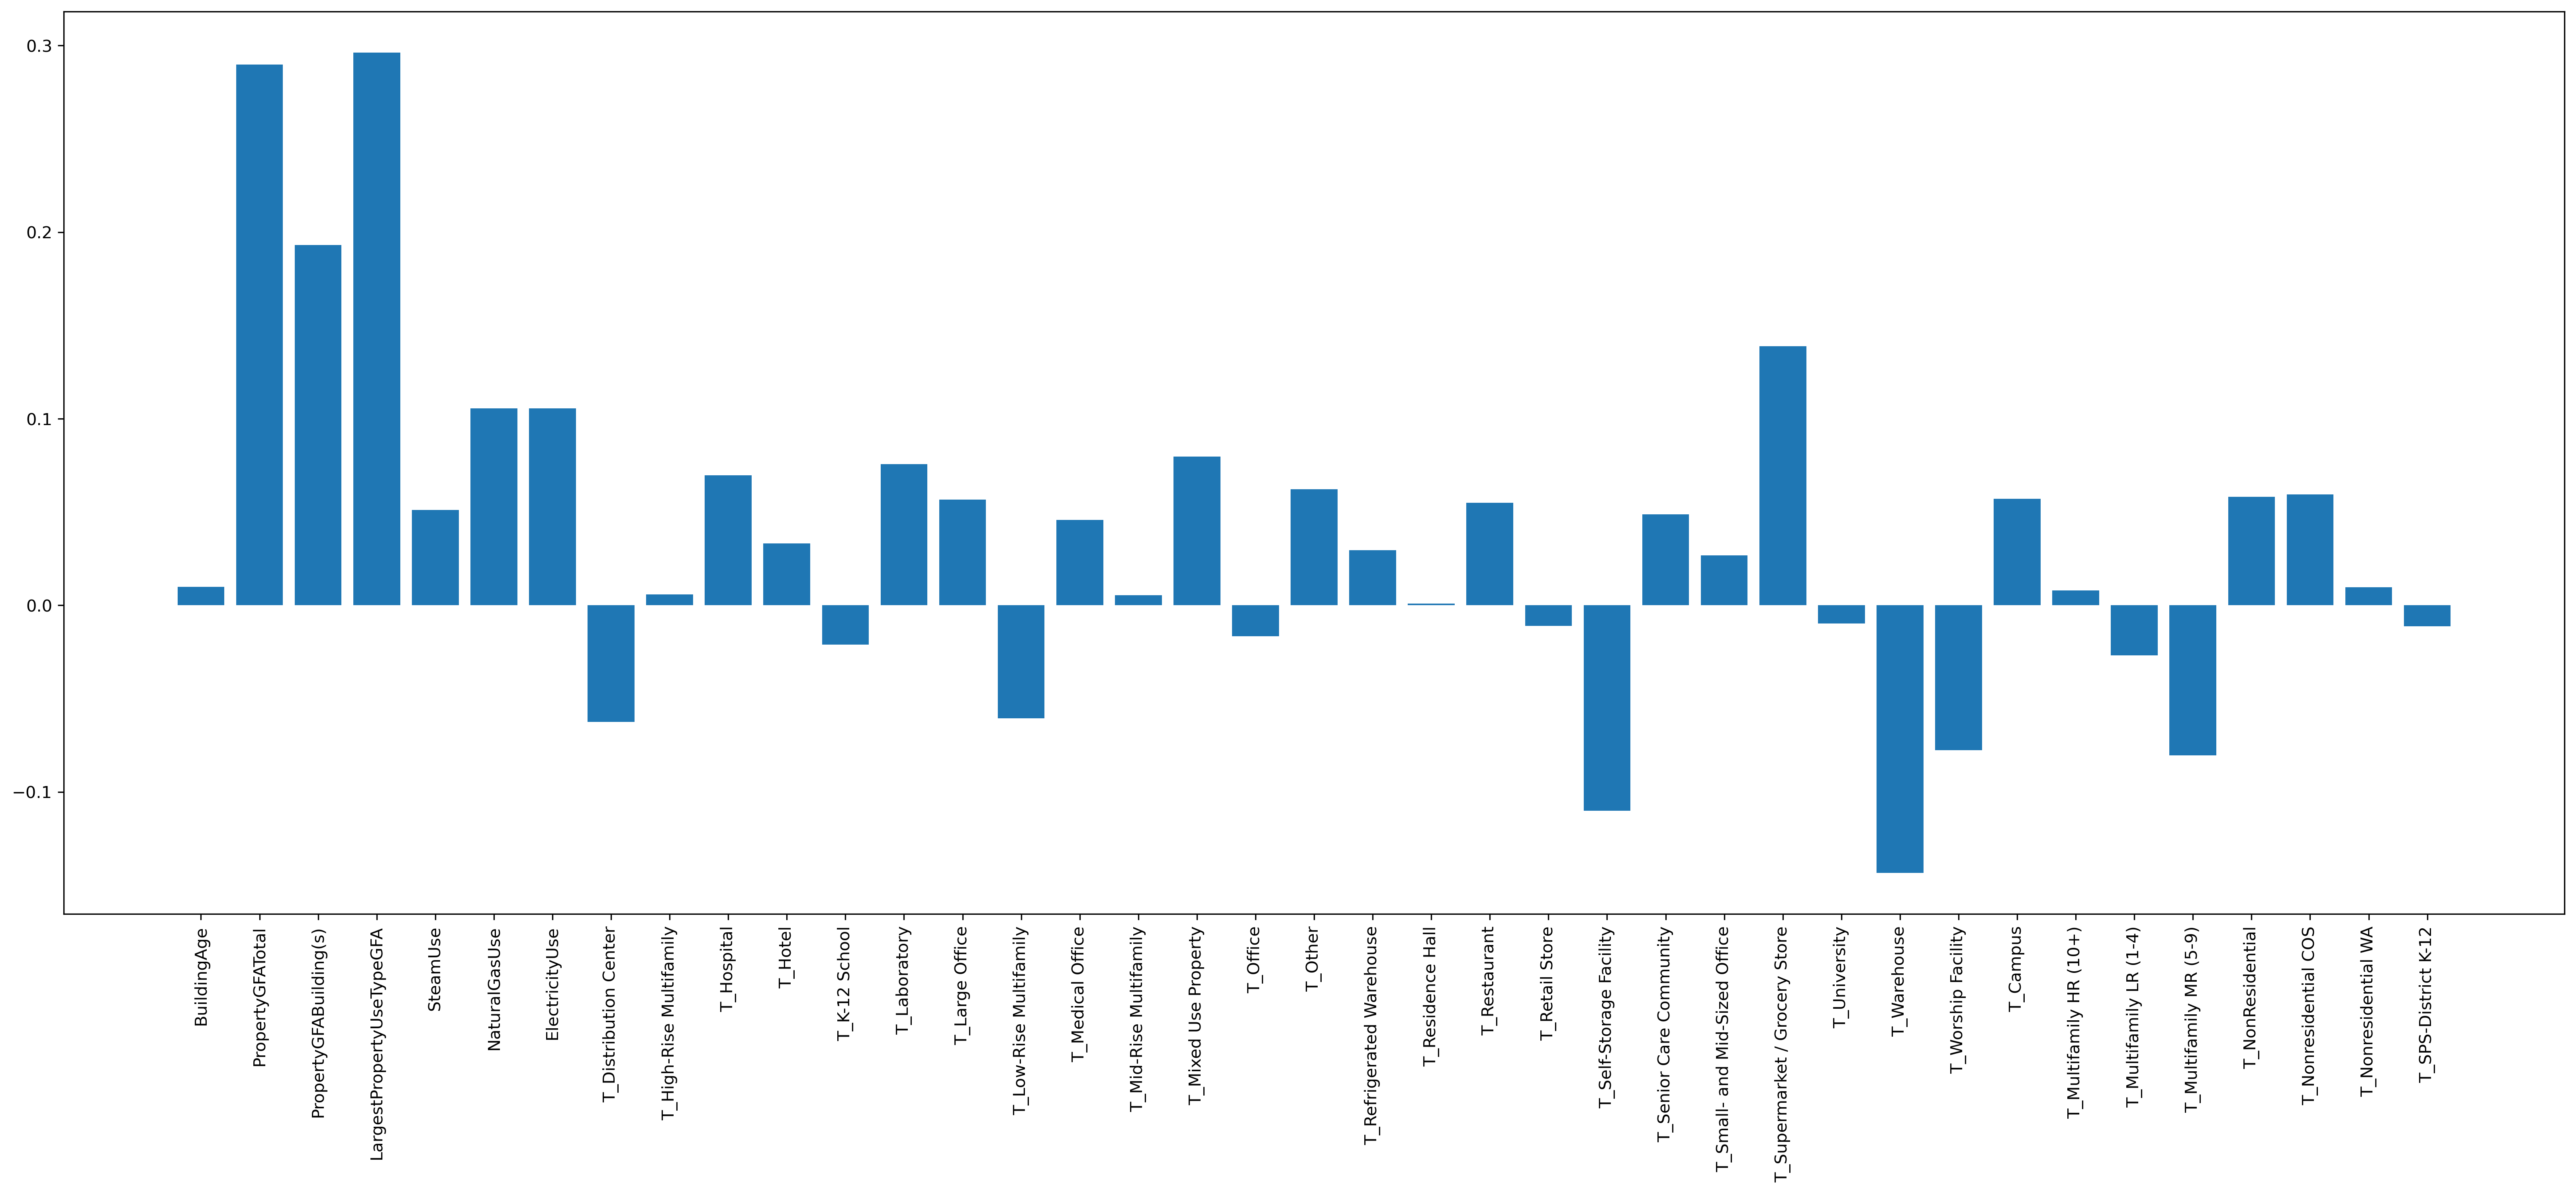

LassoCV MSE:  0.2984842056698674
LassoCV RMSE:  0.5302607864686006
LassoCV alpha 0.0021001800180018002
Score MSE model sur le jeu d'entrainement 0.28117650166629893
Score RMSE model sur le jeu d'entrainement 0.5302607864686006
Score r2 model sur le jeu d'entrainement 0.7137422464177562


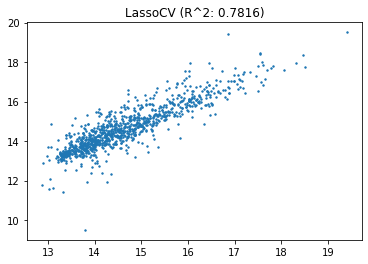

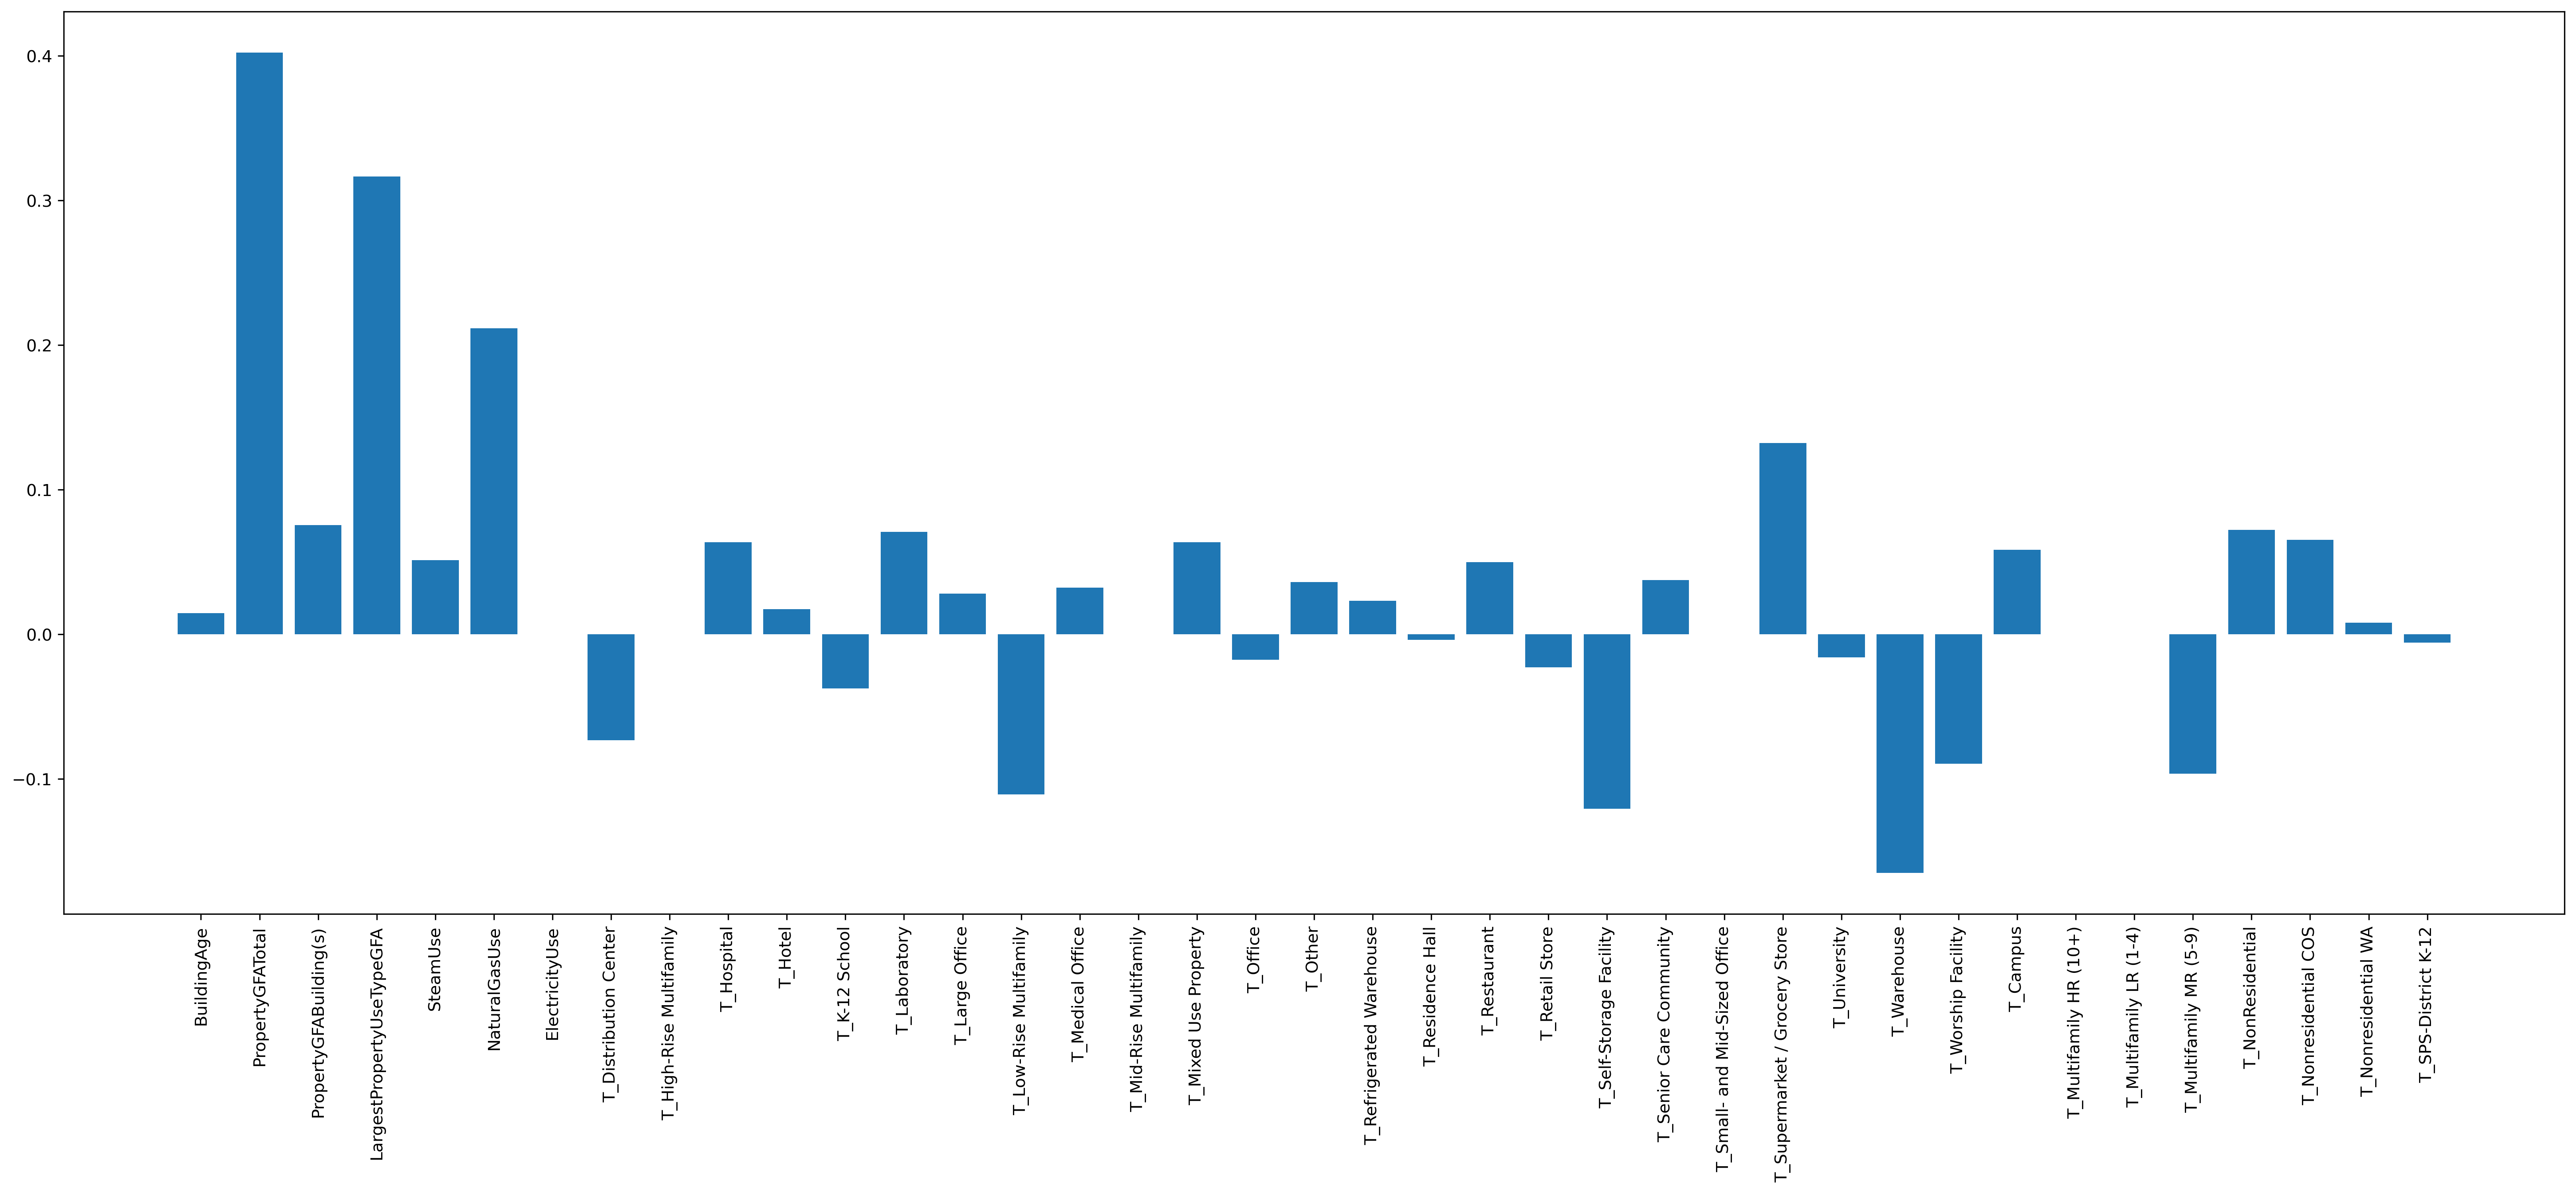

ElasticNetCV MSE:  0.29822293848298614
ElasticNetCV RMSE:  0.5306831084832615
ElasticNetCV alpha 0.021835575763053745
Score MSE model sur le jeu d'entrainement 0.28162456162945704
Score RMSE model sur le jeu d'entrainement 0.5306831084832615
Score r2 model sur le jeu d'entrainement 0.7102898560841563


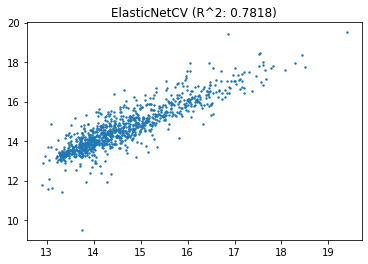

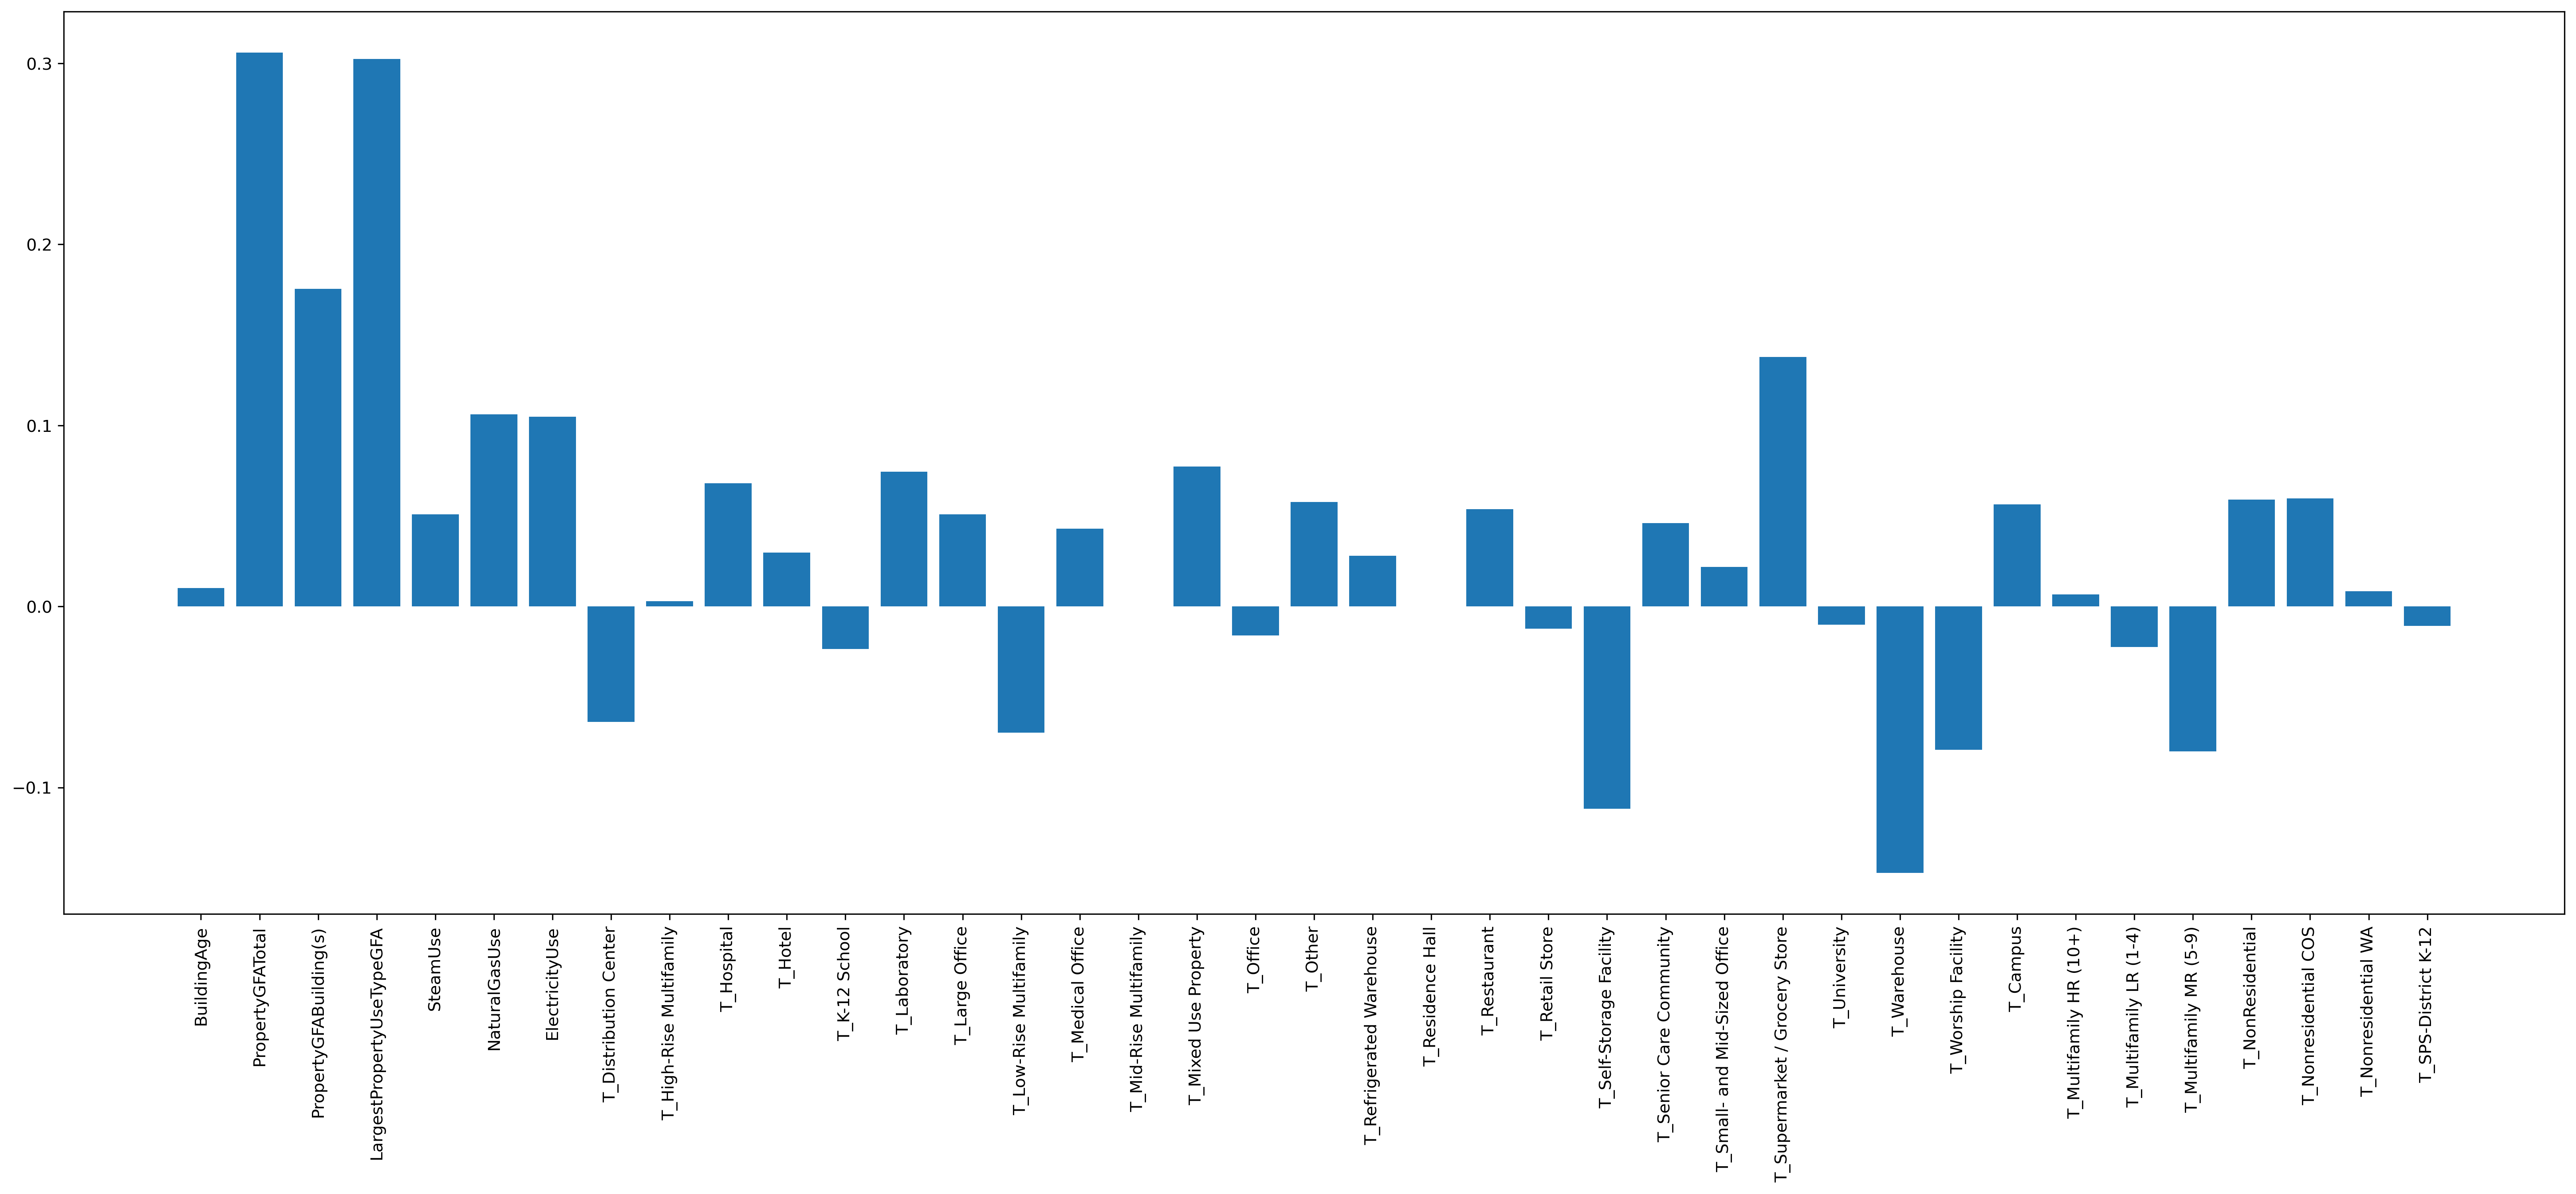

Fitting 2 folds for each of 288 candidates, totalling 576 fits
MSE:  0.2892240478401188
RMSE:  0.42561640521305333
Score MSE model sur le jeu d'entrainement 0.181149324386482
Score RMSE model sur le jeu d'entrainement 0.42561640521305333
Score r2 model sur le jeu d'entrainement 0.8152495855697264
{'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200, 'nthread': 0, 'objective': 'reg:squarederror', 'reg_alpha': 0.5, 'reg_lambda': 0.01, 'subsample': 0.7}


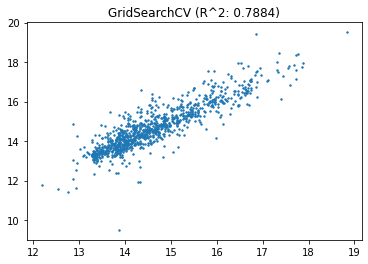

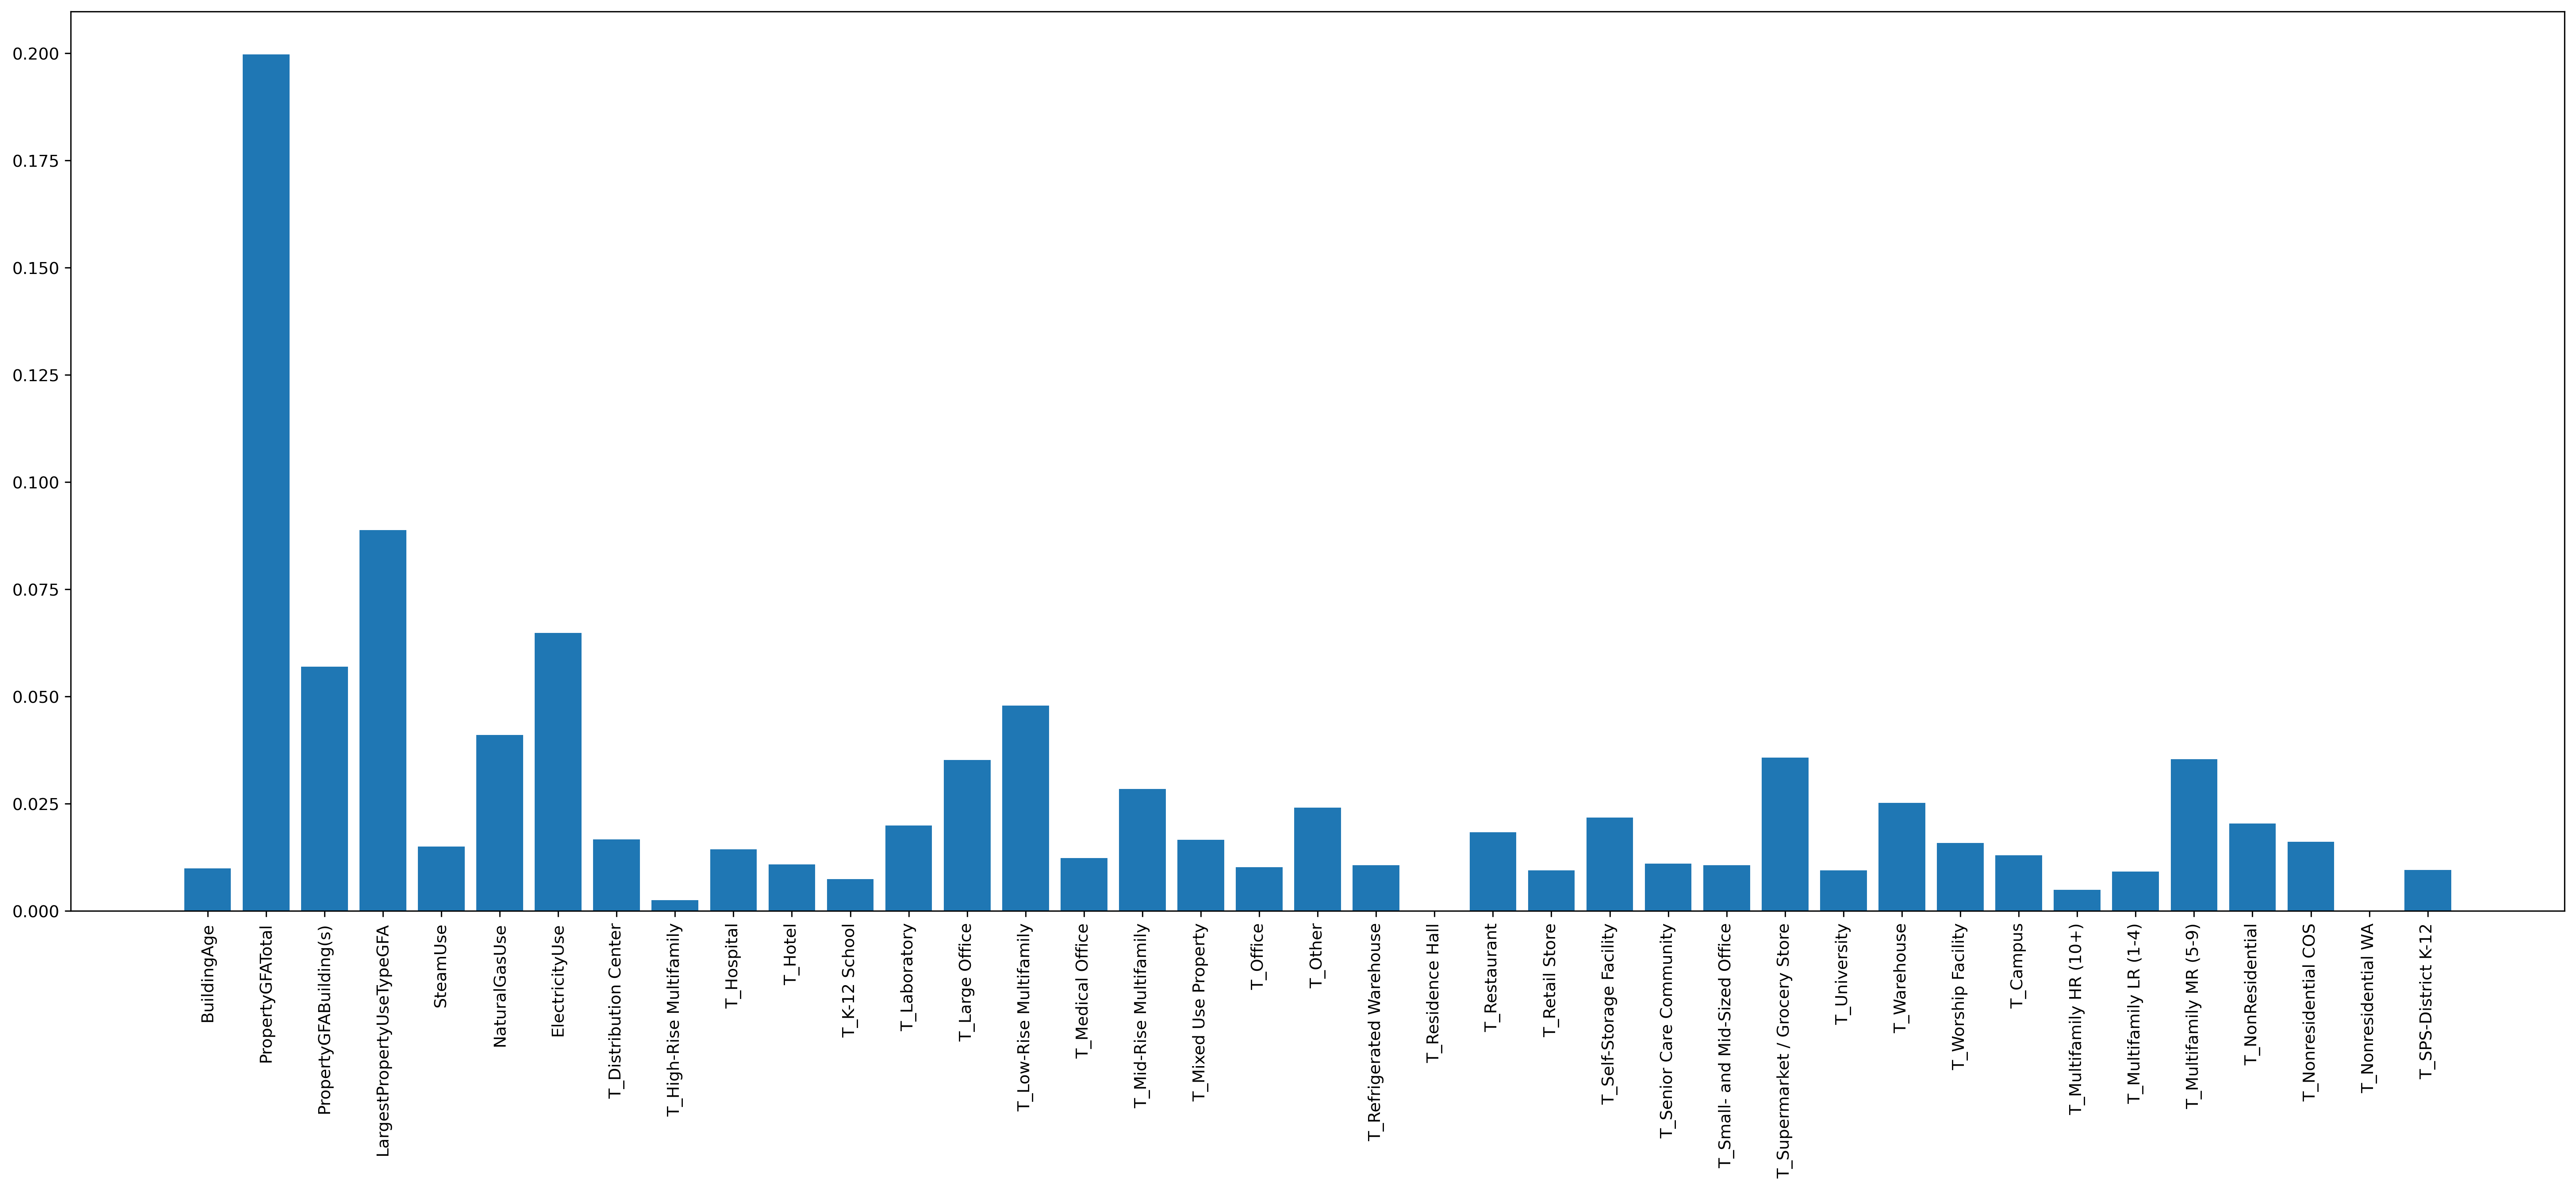

In [121]:
Test_Sans_ENERGYSTARScore(
    X_train_energy, X_test_energy, y_train_energy, y_test_energy)

## Selection

Après les tests de modèles effectués, nous choississons le modèle Lasso, pour sa performance son bonus de réduction dimensionnelle, qui permet une meilleure interprétabilité.